# OONI Data Analysis - Preliminary Exploration

In [1]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os

In [2]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [3]:
# Load the pre-processed data and set up the index based on date
data_dir = '../../Data/HR/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,resolver_asn,x_dns_flags,x_blocking_flags,title_match,http_experiment_failure,control_failure,blocking,headers_match,dns_consistency,input,accessible,body_length_match,body_proportion,x_null_null_flags,status_code_match,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-01-02,AS5391,AS5391,NaN,NaN,True,NaN,NaN,False,True,consistent,https://allo.google.com/,True,True,1.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,NaN,NaN,NaN,False,True,consistent,https://app.developer.here.com/coronavirus/,True,True,1.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,True,NaN,NaN,False,True,consistent,https://apps.crowdtangle.com/public-hub/covid19,True,True,1.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,NaN,NaN,NaN,False,True,consistent,https://app.wire.com/,True,NaN,0.000000,NaN,True,NaN
2022-01-02,AS5391,AS5391,NaN,NaN,True,NaN,NaN,False,True,consistent,https://archive.org/web/,True,True,0.999836,NaN,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS34594,AS34594,NaN,NaN,True,NaN,NaN,False,True,consistent,https://www.spotify.com/,True,True,0.988822,NaN,True,NaN
2022-12-31,AS34594,AS34594,NaN,NaN,NaN,NaN,NaN,False,True,consistent,https://www.state.gov/,True,NaN,0.000000,NaN,True,NaN
2022-12-31,AS34594,AS34594,NaN,NaN,NaN,NaN,NaN,False,False,consistent,https://www.state.gov/j/drl/,True,NaN,0.000000,NaN,True,NaN


In [4]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'http-diff', nan, 'tcp_ip', 'dns', 'http-failure'],
      dtype=object)

## (2) Data Exploration

In [5]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [6]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

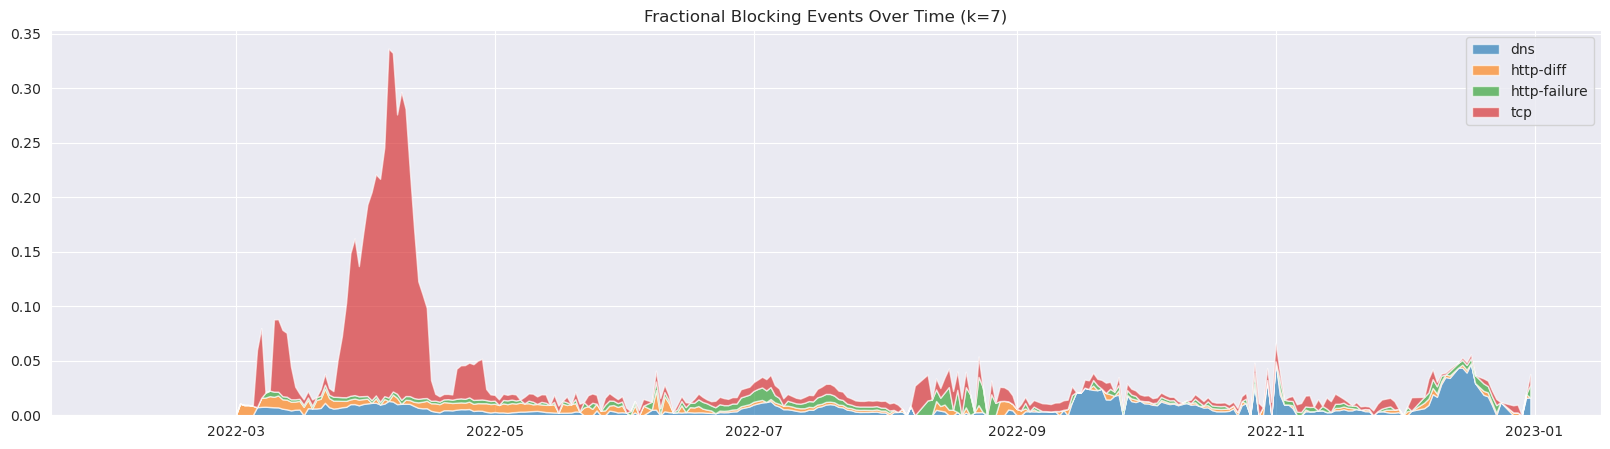

In [7]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-03-01-2022-05-01 (k=7)')

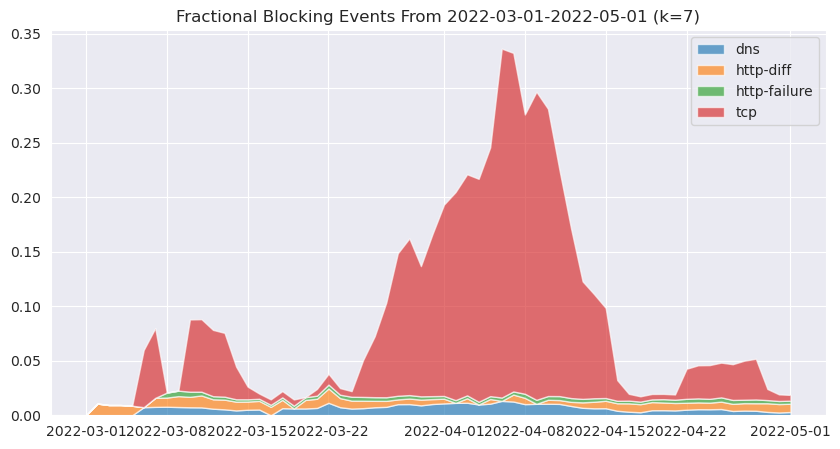

In [12]:
# Zoom in on a region of interest
start_date = '2022-03-01'
end_date = '2022-05-01'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [9]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn  \
input                                        date                   
http://128.31.0.39:9131/tor/server/authority 2022-04-17    AS5391   
                                             2022-04-17    AS5391   
                                             2022-04-17    AS5391   
                                             2022-04-17    AS5391   
                                             2022-04-18    AS5391   
...                                                           ...   
https://yandexwebcache.net/robots.txt        2022-10-02    AS5391   
https://z-lib.org/                           2022-11-04    AS5391   
                                             2022-11-04    AS5391   
                                             2022-11-14    AS5391   
                                             2022-11-15    AS5391   

                                                        resolver_asn  \
input                                        date                      
http://128.31.0.39:9131/tor/server/authority 2022-04-17       AS5391   
                                             2022-04-17       AS5391   
                                             2022-04-17       AS5391   
                                             2022-04-17       AS5391   
                                             2022-04-18       AS5391   
...                                                              ...   
https://yandexwebcache.net/robots.txt        2022-10-02       AS5391   
https://z-lib.org/                           2022-11-04       AS5391   
                                             2022-11-04       AS5391   
                                             2022-11-14      AS36692   
                                             2022-11-15       AS5391   

                                                         x_dns_flags  \
input                                        date                      
http://128.31.0.39:9131/tor/server/authority 2022-04-17          NaN   
                                             2022-04-17          NaN   
                                             2022-04-17          NaN   
                                             2022-04-17          NaN   
                                             2022-04-18          NaN   
...                                                              ...   
https://yandexwebcache.net/robots.txt        2022-10-02          NaN   
https://z-lib.org/                           2022-11-04          NaN   
                                             2022-11-04          NaN   
                                             2022-11-14          NaN   
                                             2022-11-15          NaN   

                                                         x_blocking_flags  \
input                                        date                           
http://128.31.0.39:9131/tor/server/authority 2022-04-17               NaN   
                                             2022-04-17               NaN   
                                             2022-04-17               NaN   
                                             2022-04-17               NaN   
                                             2022-04-18               NaN   
...                                                                   ...   
https://yandexwebcache.net/robots.txt        2022-10-02               NaN   
https://z-lib.org/                           2022-11-04               NaN   
                                             2022-11-04               NaN   
                                             2022-11-14               NaN   
                                             2022-11-15               NaN   

                                                        title_match  \
input                                        date                     
http://128.31.0.39:9131/tor/server/authority 2022-04-17         NaN   
                                             2022-04-17         NaN  

In [10]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
http://gaytoday.com/                           244
http://194.109.206.212/tor/server/authority    237
https://sputniknews.com/                       181
https://www.rt.com/                            162
http://www.khilafah.com/                       150
                                              ... 
https://www.reproductiverights.org/              1
https://www.rambler.ru/                          1
https://www.rackspace.com/                       1
https://www.spiegel.de/                          1
https://www.state.gov/j/drl/                     1
Length: 1336, dtype: int64

In [11]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn resolver_asn  x_dns_flags  \
input                       date                                             
http://gaytoday.com/        2022-03-02    AS5391      AS20940          NaN   
                            2022-03-03    AS5391      AS13335          NaN   
                            2022-03-03    AS5391      AS13335          NaN   
                            2022-03-05    AS5391      AS36692          NaN   
                            2022-03-08    AS5391      AS13335          NaN   
...                                          ...          ...          ...   
http://www.keptprivate.com/ 2022-04-04    AS5391      AS13335          NaN   
                            2022-04-06    AS5391      AS13335          NaN   
                            2022-04-08    AS5391      AS13335          NaN   
                            2022-04-22    AS5391      AS13335          NaN   
                            2022-11-20    AS5391      AS36692          NaN   

                                        x_blocking_flags title_match  \
input                       date                                       
http://gaytoday.com/        2022-03-02               NaN         NaN   
                            2022-03-03               NaN         NaN   
                            2022-03-03               NaN         NaN   
                            2022-03-05               NaN         NaN   
                            2022-03-08               NaN         NaN   
...                                                  ...         ...   
http://www.keptprivate.com/ 2022-04-04               NaN         NaN   
                            2022-04-06               NaN         NaN   
                            2022-04-08               NaN         NaN   
                            2022-04-22               NaN         NaN   
                            2022-11-20               NaN         NaN   

                                       http_experiment_failure  \
input                       date                                 
http://gaytoday.com/        2022-03-02                     NaN   
                            2022-03-03                     NaN   
                            2022-03-03                     NaN   
                            2022-03-05   generic_timeout_error   
                            2022-03-08                     NaN   
...                                                        ...   
http://www.keptprivate.com/ 2022-04-04   generic_timeout_error   
                            2022-04-06   generic_timeout_error   
                            2022-04-08   generic_timeout_error   
                            2022-04-22   generic_timeout_error   
                            2022-11-20                     NaN   

                                       control_failure   blocking  \
input                       date                                    
http://gaytoday.com/        2022-03-02             NaN  http-diff   
                            2022-03-03             NaN  http-diff   
                            2022-03-03             NaN  http-diff   
                            2022-03-05             NaN     tcp_ip   
                            2022-03-08             NaN  http-diff   
...                                                ...        ...   
http://www.keptprivate.com/ 2022-04-04             NaN     tcp_ip   
                            2022-04-06             NaN     tcp_ip   
                            2022-04-08             NaN     tcp_ip   
                            2022-04-22             NaN     tcp_ip   
                            2022-11-20             NaN        dns   

                                       headers_match dns_consistency  \
input                       date                                       
http://gaytoday.com/        2022-03-02          True      consistent   
                            2022-03-03          True      consistent   
                            2022-03-03    

In [44]:
sel = wmbi.loc[topw[topw > 10].index].loc[topw.index[10]]
ma = sel['blocking'] == 'dns'
sel[ma]

,probe_asn,resolver_asn,x_dns_flags,x_blocking_flags,title_match,http_experiment_failure,control_failure,blocking,headers_match,dns_consistency,accessible,body_length_match,body_proportion,x_null_null_flags,status_code_match,dns_experiment_failure
date,,,,,,,,,,,,,,,,
2022-07-16,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031078,NaN,False,NaN
2022-07-17,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031195,NaN,False,NaN
2022-07-21,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031195,NaN,False,NaN
2022-07-21,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031195,NaN,False,NaN
2022-07-22,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.030962,NaN,False,NaN
2022-07-23,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031078,NaN,False,NaN
2022-07-24,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031199,NaN,False,NaN
2022-07-24,AS5391,AS5391,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031082,NaN,False,NaN
2022-07-24,AS62161,AS15169,NaN,NaN,False,NaN,NaN,dns,True,inconsistent,False,False,0.031199,NaN,False,NaN


In [45]:
web_connectivity.loc[web_connectivity['input'] == topw.index[0]]

,probe_asn,resolver_asn,x_dns_flags,x_blocking_flags,title_match,http_experiment_failure,control_failure,blocking,headers_match,dns_consistency,input,accessible,body_length_match,body_proportion,x_null_null_flags,status_code_match,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-03-02,AS5391,AS20940,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,http://gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-03-03,AS5391,AS13335,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,http://gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-03-03,AS5391,AS13335,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,http://gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-03-04,AS5391,AS13335,NaN,NaN,NaN,NaN,NaN,False,True,consistent,http://gaytoday.com/,True,NaN,0.0,NaN,True,NaN
2022-03-05,AS5391,AS36692,NaN,NaN,NaN,generic_timeout_error,NaN,tcp_ip,NaN,consistent,http://gaytoday.com/,False,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-18,AS12417,AS12417,NaN,NaN,NaN,NaN,NaN,False,True,consistent,http://gaytoday.com/,True,NaN,0.0,NaN,True,NaN
2022-12-20,AS12417,AS12417,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,http://gaytoday.com/,False,NaN,0.0,NaN,False,NaN
2022-12-21,AS5391,AS5391,NaN,NaN,NaN,NaN,NaN,http-diff,True,consistent,http://gaytoday.com/,False,NaN,0.0,NaN,False,NaN


In [68]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [63]:
noblock_events = web_connectivity[(web_connectivity['blocking'] == 'False') | (web_connectivity['blocking'].isnull())]
noblock_grouped = noblock_events.groupby('input').size()

In [74]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [187]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
http://128.31.0.39:9131/tor/server/authority,0.000000,0.000000,0.061008,0.180371
http://131.188.40.189/tor/server/authority,0.000000,0.019126,0.002732,0.051913
http://154.35.175.225/tor/server/authority,0.000000,0.000000,0.002681,0.069705
http://171.25.193.9:443/tor/server/authority,0.000000,0.000000,0.008000,0.024000
http://193.23.244.244/tor/server/authority,0.000000,0.000000,0.000000,0.089744
...,...,...,...,...
https://xda-developers.com/,0.000000,0.000000,0.005747,0.000000
https://xe.com/,0.008000,0.000000,0.000000,0.000000
https://xhamster.com/,0.007576,0.000000,0.000000,0.000000


In [175]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
http://www.xfocus.org/,0.00000,0.017857,0.017857,0.964286
http://delicious.com/,1.00000,0.000000,0.000000,0.000000
https://vegas.williamhill.com/,1.00000,0.000000,0.000000,0.000000
https://www.888casino.com/,1.00000,0.000000,0.000000,0.000000
https://mitm.watch/,1.00000,0.000000,0.000000,0.000000
...,...,...,...,...
https://occupystreams.org/,0.00000,0.000000,0.000000,0.149485
https://mastodon.host/,0.14876,0.000000,0.000000,0.000000
http://wedo.org/,0.00000,0.000000,0.009259,0.138889


In [185]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 1.0, 'Top 100 Blocked Sites')

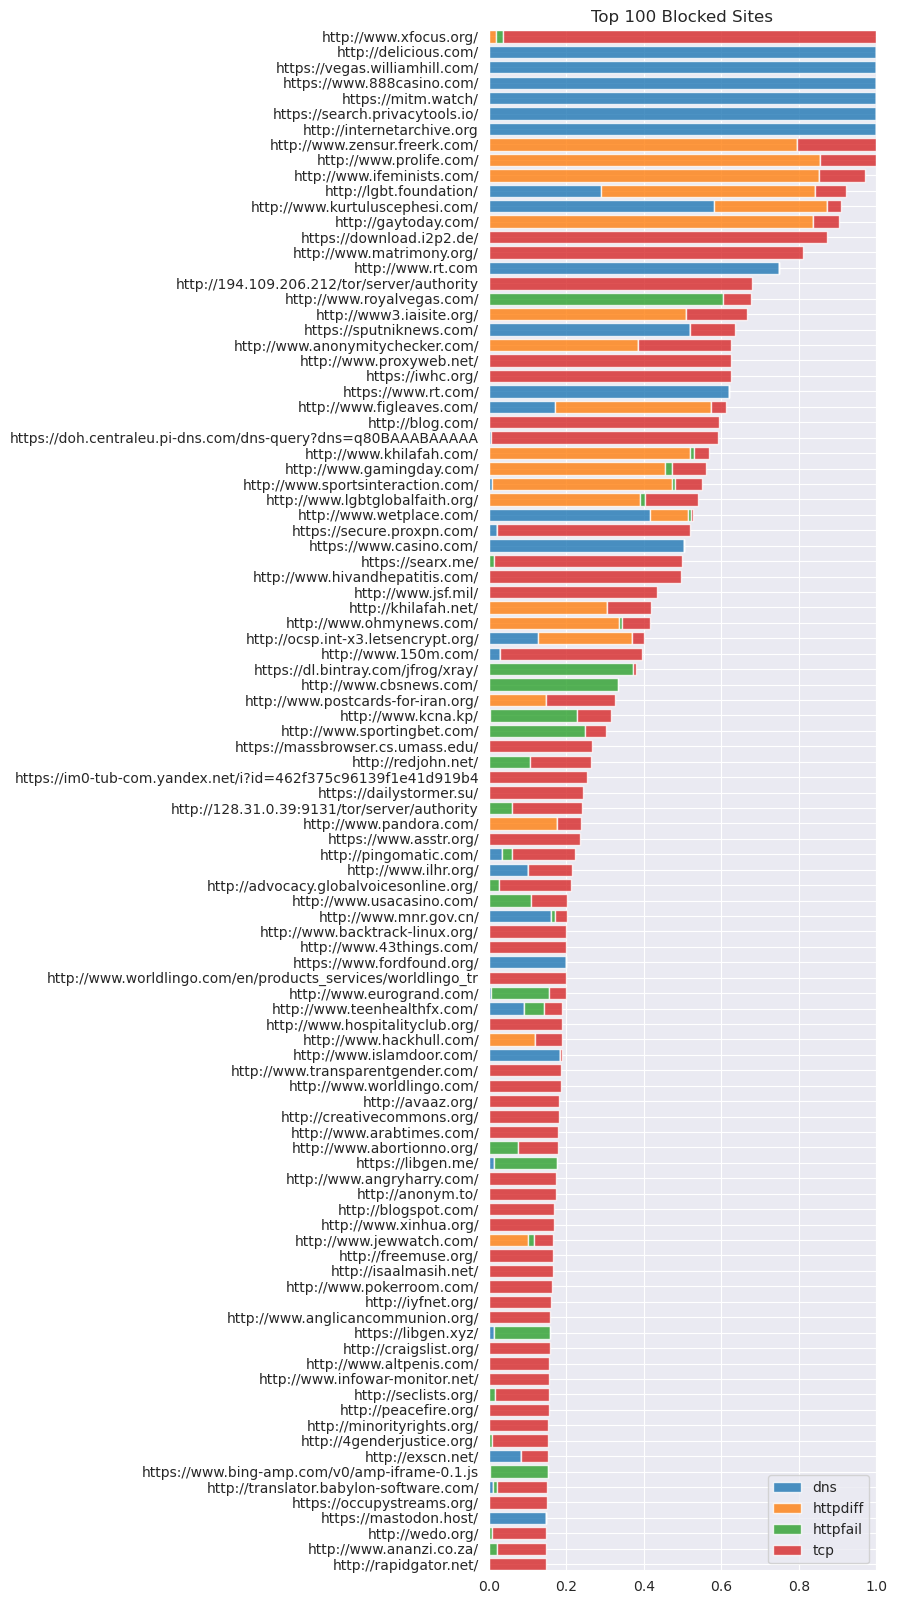

In [189]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')